<div style="background: linear-gradient(to right, #4b6cb7, #182848); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: GenAI Results Comparator</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Advanced: LLM FAQ Analysis</p>
</div>
<br>

This notebook demonstrates how to evaluate and compare responses generated by different Large Language Models (LLMs) using various metrics.

- We'll analyze FAQ responses to understand the performance and characteristics of different models.
- Lastly, we will generate visualizations to see rank the LLM models.

**Input Data Format**

- Generated Responses: Text outputs from different LLMs (stored as strings)
- Ground Truth: Reference answers from validated sources: `sc.edu`
- Data Structure: CSV/JSON files with columns/fields for:
  - Question ID
  - Question Text
  - Reference Response
  - Generated Response (for each LLM)
- Source: [RoostAI](https://github.com/csce585-mlsystems/RoostAI)

**Metrics Used**

1. N-gram Based Metrics

   - BLEU (Bilingual Evaluation Understudy)
   - ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
   - JS Divergence

2. Text Similarity Metrics

   - Jaccard Similarity
   - Levenshtein Distance

3. Semantic Similarity Metrics
   - BERTScore


### 1. Import Required Libraries

For this notebook, we'll assume the library is installed or made accessible via the path modification below.


In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
# Construct the path to the project root (two levels up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import concurrent.futures
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from math import pi

from gaico.metrics import (
    BLEU,
    ROUGE,
    JSDivergence,
    JaccardSimilarity,
    LevenshteinDistance,
    BERTScore,
)

### 2. Data Acquisition & Exploration

After importing the required libraries, we will read in the data and find some statistics.

The data is consists of University of South Carolina FAQs, official ground-truth answers, and outputs from various LLMs. It is taken from [RoostAI](https://github.com/csce585-mlsystems/RoostAI).

In [3]:
df = pd.read_csv(os.path.join("..", "data", "llm_faq", "data", "faq_responses.csv"))
df.head()

,question,answer,phi,llama,gemini,mixtral,claude,gpt
0,Can a program include more than one concentrat...,"Yes, programs may have multiple concentrations...","Yes, at the University of South Carolina (USC...","At the University of South Carolina, many unde...",Yes! Many USC programs allow you to combine c...,"Yes, at the University of South Carolina, man...","Yes, at USC, many programs offer the opportuni...","Yes, at USC, some programs offer the option to..."
1,Can I choose specific (prescribed) courses as ...,Yes. Certain programs may require courses that...,"At the University of South Carolina, the Caro...","Yes, you can choose specific courses as part o...",While the Carolina Core has general requiremen...,While the Carolina Core has a required list o...,"Yes, you can choose specific courses for the C...","Yes, you can choose specific courses for the C..."
2,Do all changes to a cross-listed course affect...,Common Reasons Proposals are Returned from the...,When a cross-listed course undergoes changes ...,According to the University of South Carolina'...,It's great you're thinking about how changes t...,"Yes, changes to a cross-listed course typical...","Yes, changes made to a cross-listed course at ...","Yes, in most cases at USC, changes to a cross-..."
3,Do prerequisites have to be enforced in Banner?,Prerequisites do not have to be enforced in Ba...,Are prerequisites required to be set and conf...,"Yes, prerequisites are enforced in Banner, whi...",It's great you're thinking about prerequisites...,While I can't directly interact with USC's sy...,"At USC, prerequisites are typically enforced i...","Yes, at the University of South Carolina, prer..."
4,How do Carolina Core Overlay courses work?,Carolina Core overlay courses meet two Carolin...,Carolina Core Overlay courses at the Universi...,Carolina Core Overlay courses are honors-level...,Carolina Core Overlay courses are a unique fea...,Carolina Core Overlay courses are USC's way t...,Carolina Core Overlay courses at USC fulfill m...,Carolina Core Overlay courses at USC allow stu...


In [4]:
# Get average word length for each column
for column in df.columns[:]:
    print(f"{column}: {df[column].apply(lambda x: len(x.split())).mean()}")

question: 8.525
answer: 81.65
phi: 82.65
llama: 63.3
gemini: 44.95
mixtral: 55.575
claude: 68.125
gpt: 65.35


### 3. Metric Caculation

We will now use Python's parrellel processing capabilities to calculate the metrics for each LLM response against the ground truth.


In [5]:
llm_names = df.columns[2:]
llm_names

Index(['phi', 'llama', 'gemini', 'mixtral', 'claude', 'gpt'], dtype='object')

In [6]:
# Initialize metric classes
metric_classes = {
    "bleu": BLEU(),
    "rouge": ROUGE(),
    "js_div": JSDivergence(),
    "jaccard": JaccardSimilarity(),
    "levenshtein": LevenshteinDistance(),
    "bert_score": BERTScore(model_type="microsoft/deberta-xlarge-mnli"),
}

In [7]:
def calculate_metrics(ground_truth, prediction):
    return {
        "BLEU": metric_classes["bleu"].calculate(ground_truth, prediction),
        "ROUGE-L": metric_classes["rouge"].calculate(ground_truth, prediction).get("rougeL", 0),
        "JSD": metric_classes["js_div"].calculate(ground_truth, prediction),
        "Jaccard": metric_classes["jaccard"].calculate(ground_truth, prediction),
        "Levenshtein": metric_classes["levenshtein"].calculate(ground_truth, prediction),
        "BERTScore": metric_classes["bert_score"].calculate(ground_truth, prediction).get("f1", 0),
    }

In [8]:
def process_row(row):
    ground_truth = row["answer"]
    return {model: calculate_metrics(ground_truth, row[model]) for model in llm_names}

In [9]:
# Convert DataFrame to list of dictionaries
data = df.to_dict("records")

In [10]:
# Use concurrent.futures for parallelization
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all tasks
    future_to_row = {executor.submit(process_row, row): row for row in data}

    # Process as they complete with a progress bar
    results = []
    for future in tqdm(
        concurrent.futures.as_completed(future_to_row),
        total=len(data),
        desc="Processing",
    ):
        results.append(future.result())

Processing: 100%|██████████| 40/40 [00:43<00:00,  1.10s/it]


In [11]:
# Restructure the results
results = {model: [row[model] for row in results] for model in llm_names}

In [12]:
# Save results
with open(os.path.join("..", "data", "llm_faq", "data", "response_metrics.pkl"), "wb") as f:
    pickle.dump(results, f)

### 4. Visualization

Next, we will create custom visualizations to rank the LLMs based on the calculated metrics.

**a. Line Plots**


In [13]:
def create_line_plots(results):
    """
    Creates line plots for each metric across models and saves them.

    :param results: A Dictionary containing the metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    for metric in metrics:
        # Extract scores for the current metric
        metric_scores = {
            model: [result[metric] for result in results[model]] for model in llm_models
        }

        # Create figure and axis
        fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)

        # Plot each model's metric scores
        for model in llm_models:
            ax.plot(
                range(1, len(metric_scores[model]) + 1),
                metric_scores[model],
                marker="o",
                label=model,
                zorder=2,
            )

        # Add grid with improved styling
        ax.grid(which="major", axis="x", color="#DAD8D7", alpha=0.5, zorder=1)
        ax.grid(which="major", axis="y", color="#DAD8D7", alpha=0.5, zorder=1)

        # Format x-axis
        ax.set_xlabel("Question Number", fontsize=12, labelpad=10)
        ax.xaxis.set_tick_params(pad=5, labelsize=12)
        ax.set_xticks(range(1, len(metric_scores[llm_models[0]]) + 1))

        # Format y-axis
        ax.set_ylabel(f"{metric} Score", fontsize=12, labelpad=10)
        ax.yaxis.set_tick_params(pad=5, labelsize=12)

        # Add a title
        ax.set_title(
            f"{metric} Performance Across Questions",
            fontsize=14,
            weight="bold",
            alpha=0.8,
            pad=15,
        )

        # Remove top and right spines
        ax.spines[["top", "right"]].set_visible(False)

        # Make left and bottom spines thicker
        ax.spines["left"].set_linewidth(1.1)
        ax.spines["bottom"].set_linewidth(1.1)

        # Add a legend
        ax.legend(loc="best", fontsize=12, frameon=False)

        # Add in the subtitle (optional, based on needs)
        fig.text(
            x=0.05,
            y=0.93,
            s=f"{metric} Metric Comparison",
            transform=fig.transFigure,
            ha="left",
            fontsize=14,
            weight="bold",
            alpha=0.8,
        )

        # Add a custom line and rectangle to the plot for a polished look
        ax.plot(
            [0.05, 0.9],
            [0.98, 0.98],
            transform=fig.transFigure,
            clip_on=False,
            color="#FFD700",
            linewidth=0.6,
        )
        ax.add_patch(
            plt.Rectangle(
                (0.05, 0.98),
                0.04,
                -0.02,
                facecolor="#FFD700",
                transform=fig.transFigure,
                clip_on=False,
                linewidth=0,
            )
        )

        # Set a white background
        fig.patch.set_facecolor("white")

        # Adjust layout
        plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

        # Save the plot
        save_dir = os.path.join("..", "data", "llm_faq", "plots", "line")
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f"{save_dir}/{metric}_line_plot.png", bbox_inches="tight")
        plt.close()

In [14]:
create_line_plots(results)

**b. Radar Charts**


In [15]:
def create_radar_plot(results):
    """
    Creates a radar plot to compare all models across different metrics.

    :param results: A dictionary containing metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    # Create a figure
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(polar=True))

    # Number of variables (metrics)
    num_metrics = len(metrics)

    # Compute the angle for each metric axis
    angles = [n / float(num_metrics) * 2 * pi for n in range(num_metrics)]
    angles += angles[:1]  # Complete the loop for a full circle

    # Plot each model's scores
    for model in llm_models:
        metric_scores = [
            np.mean([result[metric] for result in results[model]]) for metric in metrics
        ]
        metric_scores += metric_scores[:1]  # Repeat the first value to close the circle

        # Plot the data for each model
        ax.plot(angles, metric_scores, linewidth=2, linestyle="solid", label=model)
        ax.fill(angles, metric_scores, alpha=0.25)

    # Add the metric labels on the plot
    plt.xticks(angles[:-1], metrics, color="grey", size=12)

    # Set the y-label for the metrics (assuming scores are comparable)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.yaxis.grid(True, color="#DAD8D7")

    # Add a title
    plt.title("LLM Performance Across Multiple Metrics", size=14, weight="bold", pad=20)

    # Add legend
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1), fontsize=12, frameon=False)

    # Set a white background for the figure
    fig.patch.set_facecolor("white")

    # Save the plot
    save_dir = os.path.join("..", "data", "llm_faq", "plots", "radar_charts")
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{save_dir}/overall_radar_chart.png", bbox_inches="tight")

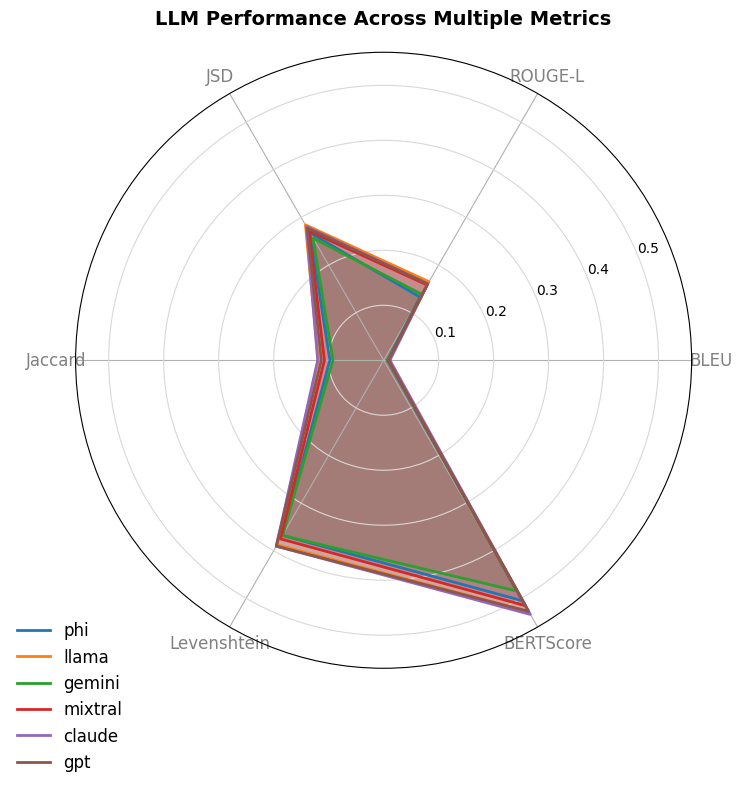

In [16]:
create_radar_plot(results)

In [17]:
def create_individual_radar_charts(results):
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    for metric in metrics:
        # Extract scores for the current metric
        metric_scores = {
            model: [result[metric] for result in results[model]] for model in llm_models
        }

        # Set up the radar chart
        angles = np.linspace(0, 2 * np.pi, len(metric_scores[llm_models[0]]), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))  # complete the polygon

        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="polar"))

        for model in llm_models:
            values = metric_scores[model]
            values = np.concatenate((values, [values[0]]))  # complete the polygon
            ax.plot(angles, values, "o-", linewidth=2, label=model)
            ax.fill(angles, values, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([f"Q{i + 1}" for i in range(len(angles) - 1)])
        ax.set_ylim(0, max([max(scores) for scores in metric_scores.values()]))
        ax.grid(True)

        plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
        plt.title(f"{metric} Performance Comparison")

        save_dir = os.path.join("..", "data", "llm_faq", "plots", "radar_charts")
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f"{save_dir}/{metric}_radar_chart.png", bbox_inches="tight")
        plt.close()

In [18]:
create_individual_radar_charts(results)

**c. Heatmaps**


In [19]:
def create_overall_heatmap(results):
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    # Calculate average scores for each model and metric
    avg_scores = {
        model: {
            metric: np.mean([result[metric] for result in results[model]]) for metric in metrics
        }
        for model in llm_models
    }

    # Create a DataFrame from the average scores
    heatmap_data = pd.DataFrame(avg_scores).T

    # Apply z-score normalization to make the heatmap more informative
    heatmap_data = heatmap_data.apply(zscore)

    plt.figure(figsize=(12, 8))
    sns.heatmap(
        heatmap_data,
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        cbar_kws={"label": "Z-score"},
    )

    plt.title("Overall LLM Performance Heatmap (Z-score normalized)")
    plt.xlabel("Metrics")
    plt.ylabel("LLM Models")

    save_dir = os.path.join("..", "data", "llm_faq", "plots", "heatmaps")
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{save_dir}/overall_heatmap.png", bbox_inches="tight")
    plt.close()

In [20]:
create_overall_heatmap(results)

In [21]:
def create_individual_heatmaps(results):
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    for metric in metrics:
        # Extract scores for the current metric
        metric_scores = {
            model: [result[metric] for result in results[model]] for model in llm_models
        }

        # Create a DataFrame from the scores
        df_scores = pd.DataFrame(metric_scores)

        # Create heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(
            df_scores,
            cmap="coolwarm",
            annot=True,
            fmt=".2f",
            cbar_kws={"label": metric},
        )

        plt.title(f"{metric} Performance Heatmap")
        plt.xlabel("LLM Models")
        plt.ylabel("Questions")

        save_dir = os.path.join("..", "data", "llm_faq", "plots", "heatmaps")
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        plt.savefig(f"{save_dir}/{metric}_heatmap.png", bbox_inches="tight")
        plt.close()

In [22]:
create_individual_heatmaps(results)

**4. Bar Plot**


In [23]:
def create_average_bar_plot(results):
    """
    Creates a bar plot to compare average performance of models across all metrics.

    :param results: A dictionary containing metric scores for each model.
    """
    llm_models = list(results.keys())
    metrics = list(results[llm_models[0]][0].keys())

    # Calculate average scores per model
    avg_scores = {
        model: np.mean(
            [np.mean([result[metric] for result in results[model]]) for metric in metrics]
        )
        for model in llm_models
    }

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6), dpi=96)

    # Plot the average scores for each model
    ax.barh(
        list(avg_scores.keys()),
        list(avg_scores.values()),
        color="skyblue",
        edgecolor="grey",
    )

    # Format x-axis
    ax.set_xlabel("Average Metric Score", fontsize=12, labelpad=10)
    ax.xaxis.set_tick_params(pad=5, labelsize=12)

    # Format y-axis
    ax.set_ylabel("Models", fontsize=12, labelpad=10)
    ax.yaxis.set_tick_params(pad=5, labelsize=12)

    # Add a title
    ax.set_title(
        "Average Performance of Models Across Metrics",
        fontsize=14,
        weight="bold",
        alpha=0.8,
        pad=15,
    )

    # Remove top and right spines
    ax.spines[["top", "right"]].set_visible(False)

    # Make left and bottom spines thicker
    ax.spines["left"].set_linewidth(1.1)
    ax.spines["bottom"].set_linewidth(1.1)

    # Add grid
    ax.grid(which="major", axis="x", color="#DAD8D7", alpha=0.5)

    # Set a white background
    fig.patch.set_facecolor("white")

    # Save the plot
    save_dir = os.path.join("..", "data", "llm_faq", "plots", "bar")
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{save_dir}/overall_bar_chart.png", bbox_inches="tight")

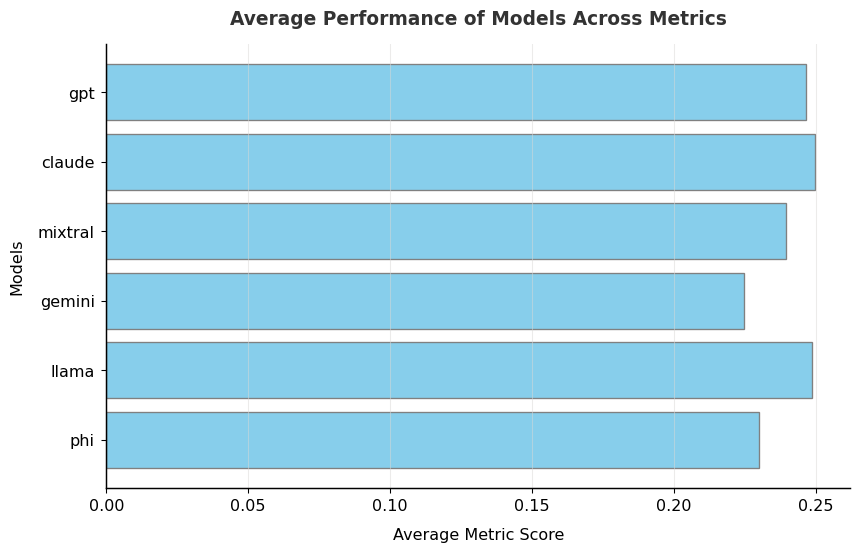

In [24]:
create_average_bar_plot(results)